In [223]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, RepeatVector, InputLayer, Reshape
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [ ]:
class Evaluation:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true

    def nrmse(self):
        mse = mean_squared_error(self.y_true, self.y_pred)
        rmse = np.sqrt(mse)
        return rmse / (self.y_true.max() - self.y_true.min())

    def mase(self):
        n = len(self.y_true)
        d = np.abs(np.diff(self.y_true)).sum() / (n - 1)
        errors = np.abs(self.y_true - self.y_pred)
        return errors.mean() / d

    def mape(self):
        return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100



In [226]:
class GeneratePlots:
    def __init__(self, processor):
        self.processor = processor
        
    def plot_model_evaluation(self, y_test, y_pred):
        if y_test.ndim == 4:
            M = y_test.shape[2]
            SNR_values = y_test.shape[3]  # Number of SNR values
        else:
            M = y_test.shape[2]  # Number of users
            SNR_values = 1  # No SNR dimension
        # Ensure y_test and y_pred are reshaped to (num_samples, time steps, users, features)
        # Assuming the last dimension has the real and imaginary parts
        # Here, reshape is needed only if y_test and y_pred don't already match this form
        K = y_test.shape[0]
        time_steps = range(30)

        for user in range(M):
            plt.figure(figsize=(20, 10))

            # Extract the real and imaginary parts of the received signals for each user
            real_test = y_test[0:30, :, user, 0].reshape(-1)
            imag_test = y_test[0:30, :, user, 1].reshape(-1)
            real_pred = y_pred[0:30, :, user, 0].reshape(-1)
            imag_pred = y_pred[0:30, :, user, 1].reshape(-1)

            # Calculate the amplitude of the received signals for each user
            amplitude_test = np.sqrt(real_test**2 + imag_test**2)
            amplitude_pred = np.sqrt(real_pred**2 + imag_pred**2)

            # Normalize the amplitudes
            max_amplitude = np.max(amplitude_test)
            normalized_amplitude_test = amplitude_test / max_amplitude
            normalized_amplitude_pred = amplitude_pred / max_amplitude

            # Plot the normalized received power for each user and SNR
            plt.plot(time_steps, normalized_amplitude_test, label=f'User {user + 1} Test')
            plt.plot(time_steps, normalized_amplitude_pred, '--', label=f'User {user + 1} Pred')

            # Label the axes and create a title and legend
            plt.xlabel('Time Step')
            plt.ylabel(f'Cascaded channel at user {user + 1}')
            plt.legend()
            plt.grid(True)
            plt.ylim([0, 1.1 * max_amplitude])
            plt.show()

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_model_metrics(self, y_test, y_pred):

        y_pred_flat = y_pred.reshape(-1, 2)  # Flatten to 2D
        y_test_flat = y_test.reshape(-1, 2)  # Flatten to 2D
        # Calculate metrics
        nrmse_val = Evaluation.nrmse(y_test, y_pred)
        mase_val = Evaluation.mase(y_test, y_pred)
        mape_val = Evaluation.mape(y_test, y_pred)
        r2_val = r2_score(y_test, y_pred)

        print(f"NRMSE: {nrmse_val}")
        print(f"MASE: {mase_val}")
        print(f"MAPE: {mape_val}")
        print(f"R2 Score: {r2_val}")

        # Metrics for plotting
        metrics = ['NRMSE', 'MASE', 'MAPE', 'R2 Score']
        values = [nrmse_val, mase_val, mape_val, r2_val]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(metrics, values, color='skyblue')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title('Model Evaluation Metrics')
        plt.ylim([0, max(values) + 0.05 * max(values)])  # Adjust y-axis limit


In [234]:
class CNNLSTMModel:
    def __init__(self, processor):
        self.processor = processor
        self.model = Sequential()
        self.build_model()

    def build_model(self):
        t_i = self.processor.t_i
        M = self.processor.M
        N_t = self.processor.N_t
        N_r = self.processor.N_r
        t_o = self.processor.t_o

        self.model.add(InputLayer(input_shape=(t_i, M, 2*N_t*N_r)))
        self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(RepeatVector(t_o))
        self.model.add(LSTM(16, activation='tanh', return_sequences=True))
        self.model.add(LSTM(16, return_sequences=True))
        self.model.add(TimeDistributed(Dense(4)))
        self.model.add(Reshape((t_o, M, 2*N_t*N_r)))
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, X_train, y_train, validation_split=0.1, epochs=4000, batch_size=32):
        #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        return self.model.fit(X_train, y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)
    
    def predict_model(self, X_test):
        return self.model.predict(X_test)

In [218]:
class DatasetProcessor:
    def __init__(self, file_path, t_i, t_o, N_t, N_r):
        self.file_path = file_path
        self.t_i = t_i  # Number of input time steps
        self.t_o = t_o  # Number of output time steps
        self.N_t = N_t  # Number of transmit antennas
        self.N_r = N_r  # Number of receive antennas
        self.M = None
        self.K = None
        self.SNR = None

    def load_data(self):
        # Load the .mat dataset
        data = scipy.io.loadmat(self.file_path)
        Y = data["Y"]
        G = data["G"]
        if Y.ndim == 4:
            Y = np.transpose(Y, (2, 1, 3, 0))
            self.SNR = Y.shape[2]
        else:
            Y = np.transpose(Y, (2, 1, 0))
        if G.ndim == 4:
            G = np.transpose(G, (2, 1, 3, 0))
        else:
            G = np.transpose(G, (2, 1, 0))
        return Y, G
    
    def preprocess_data(self, Y, G):
        self.K = Y.shape[0]  # Number of timesteps
        self.M = Y.shape[1]  # Number of users
        Sample = self.K - self.t_i - self.t_o + 1

        # Create sequences for input and output
        X = np.array([Y[i:i+self.t_i] for i in range(Sample)])
        y = np.array([G[i + self.t_i:i + self.t_i + self.t_o] for i in range(Sample)])
        return X, y
    
    def normalize_data(self, X, y):
        # Normalize data
        scaler_X = MinMaxScaler()
        X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(y.reshape(-1, y.shape[-1])).reshape(y.shape)
        return X_scaled, y_scaled
    
    def split_data(self, X_scaled, y_scaled):
        # Split the dataset
        return train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

    def reshape_for_cnn(self, X_train, X_test):
        # Reshape for CNN input
        t_i, M = X_train.shape[1], X_train.shape[2]
        return (X_train.reshape((-1, t_i, M, 2*self.N_t*self.N_r)).astype('float32'),
                X_test.reshape((-1, t_i, M, 2*self.N_t*self.N_r)).astype('float32'))


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 20, 2, 64)         448       
                                                                 
 conv2d_83 (Conv2D)          (None, 20, 2, 64)         12352     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 10, 1, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 640)               0         
                                                                 
 repeat_vector_40 (RepeatVe  (None, 1, 640)            0         
 ctor)                                                           
                                                                 
 lstm_80 (LSTM)              (None, 1, 16)           

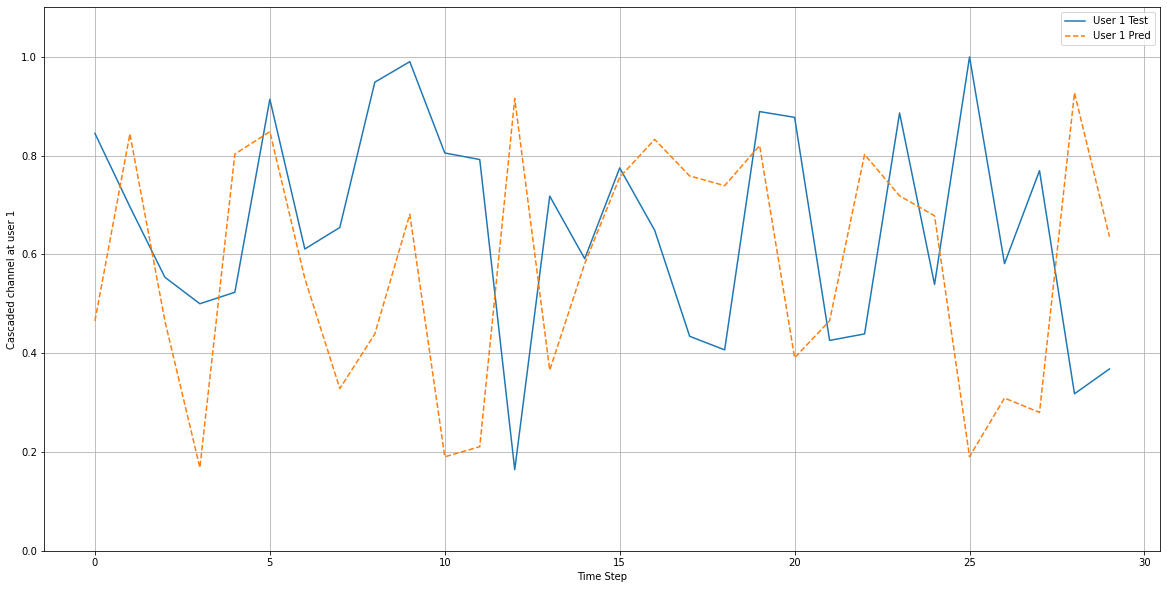

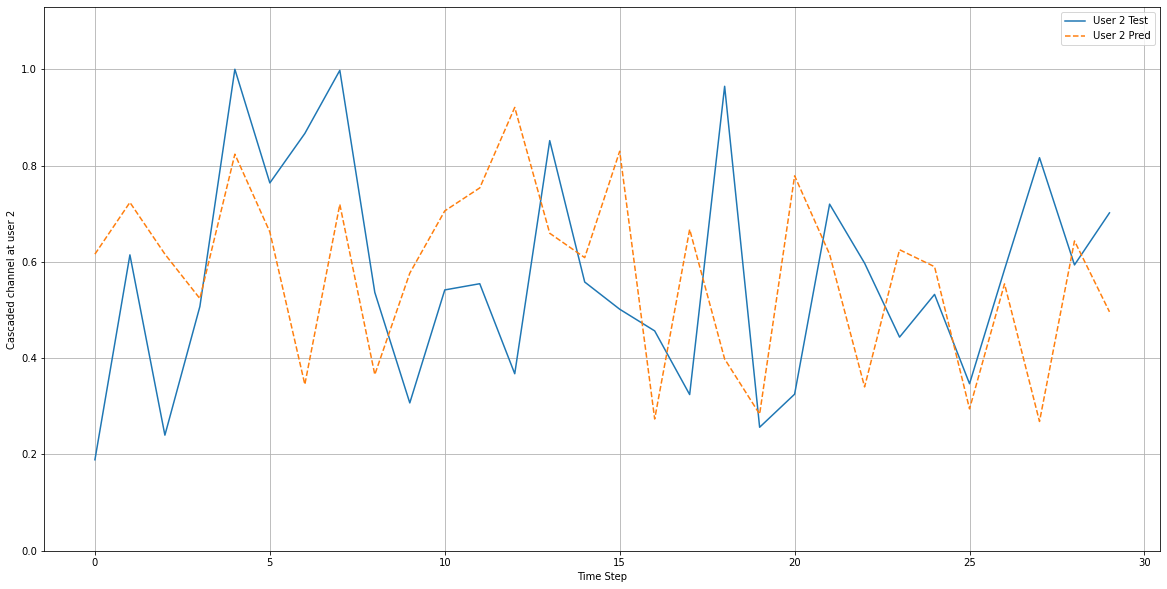

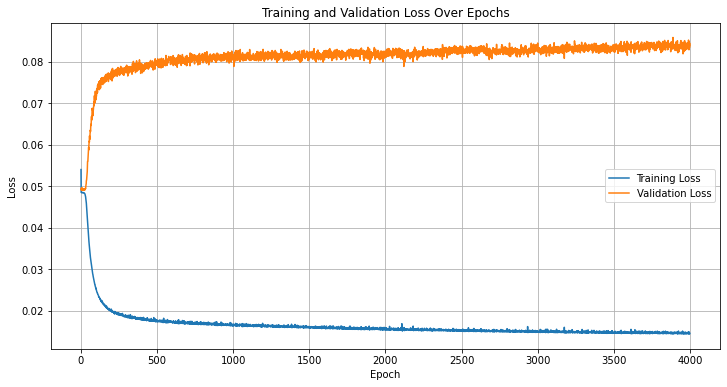

In [235]:
def main():
    processor = DatasetProcessor("dataset.mat", 20, 1, 1, 1)
    Y, G = processor.load_data()
    
    if Y.ndim == 4:
        for snr_index in range(processor.SNR):
            print(f"Processing SNR index: {snr_index + 1}/{processor.SNR}")
            
            Y_snr = Y[:, :, snr_index, :]
            G_snr = G[:, :, snr_index, :]
            
            X, y = processor.preprocess_data(Y_snr, G_snr)
            X_scaled, y_scaled = processor.normalize_data(X, y)
            X_train, X_test, y_train, y_test = processor.split_data(X_scaled, y_scaled)
            X_train, X_test = processor.reshape_for_cnn(X_train, X_test)
        
            model = CNNLSTMModel(processor)
            history = model.train_model(X_train, y_train)
            y_pred = model.predict_model(X_test)
            plotter = GeneratePlots(processor)
            plotter.plot_model_evaluation(y_test, y_pred)
            plotter.plot_training_history(history)
    else:
        X, y = processor.preprocess_data(Y, G)
        X_scaled, y_scaled = processor.normalize_data(X, y)
        X_train, X_test, y_train, y_test = processor.split_data(X_scaled, y_scaled)
        X_train, X_test = processor.reshape_for_cnn(X_train, X_test)
    
        model = CNNLSTMModel(processor)
        history = model.train_model(X_train, y_train)
        y_pred = model.predict_model(X_test)
        plotter = GeneratePlots(processor)
        plotter.plot_model_evaluation(y_test, y_pred)
        plotter.plot_training_history(history)

main()